In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import train_loop
from DE_Pytorch import DE
from torchsummary import summary

In [2]:
def get_data(num_symbols, sigma):
    
    symbol_set = [3, 1, -1, -3,] # all symbols that we use
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)

    gain_factor = np.max(np.convolve(CS.h, CS.h))
    upsampled = CS.upsample(v=False)
    Tx = np.convolve(upsampled, CS.h)
    Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise
    
    X = torch.tensor(Tx)
    X = X.view(1, 1, -1).float() # reshape and cast to float so PyTorch understands it
    y = symbol_seq
    classes = np.array(symbol_set)
    num_classes = len(classes)

    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X, y

def make_net():
    net = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
    for param in net.parameters():
        param.requires_grad = False
    return net

In [17]:
# Create Data
Xtrain, ytrain = get_data(num_symbols=10000, sigma=2)
Xtest, ytest = get_data(num_symbols=10000, sigma=2)

# Create 1D Convolutional Neural Network with PyTorch and define optimizer and loss
NN = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-3)

D = DE(objective_function=torch.nn.CrossEntropyLoss(), population_function=make_net, 
       X=Xtrain, y=ytrain, Xtest=Xtest, ytest=ytest, F=0.55, cr=0.85, use_cuda=False)
#summary(make_net(), input_size=(1, 1, 8063))

In [ ]:
# DE Training

#best_agent = D.evolution(num_epochs=10000, verbose=True, print_epoch=100)
best_agent, opt_agent = D.early_stop_training(patience=500, measure='accuracy')

#D.evaluate()
acc = torch.sum(D.best_agent.to('cpu')(Xtest).argmax(axis=1) == ytest)/len(ytest)
print('Accuracy:', acc.item())

1: Test Accuracy Rising  0.40209999680519104
7: Test Accuracy Rising  0.4372999966144562
17: Test Accuracy Rising  0.4438000023365021
21: Test Accuracy Rising  0.44670000672340393
31: Test Accuracy Rising  0.4968000054359436
99: Test Accuracy Rising  0.5924999713897705
178: Test Accuracy Rising  0.6381999850273132
243: Test Accuracy Rising  0.6510999798774719
250: Test Accuracy Rising  0.6610999703407288
265: Test Accuracy Rising  0.6977999806404114
313: Test Accuracy Rising  0.7074000239372253
319: Test Accuracy Rising  0.7152000069618225
332: Test Accuracy Rising  0.7347000241279602
351: Test Accuracy Rising  0.7505000233650208
416: Test Accuracy Rising  0.7529000043869019
440: Test Accuracy Rising  0.7560999989509583
482: Test Accuracy Rising  0.7807999849319458
497: Test Accuracy Rising  0.7936000227928162
533: Test Accuracy Rising  0.7975999712944031
590: Test Accuracy Rising  0.8021000027656555
613: Test Accuracy Rising  0.8044000267982483
635: Test Accuracy Rising  0.81980001926

In [44]:

Xtrain, ytrain = get_data(num_symbols=100000, sigma=2)
Xtest, ytest = get_data(num_symbols=100000, sigma=2)

In [45]:
acc = torch.sum(opt_agent.to('cpu')(Xtest).argmax(axis=1) == ytest)/len(ytest)
print('Accuracy:', acc.item())

Accuracy: 0.8723800182342529


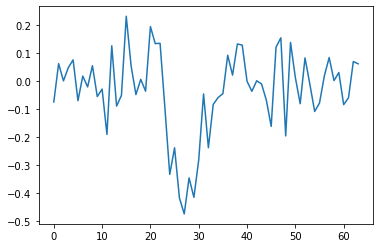

In [47]:
plt.plot(list(opt_agent.parameters())[0].detach()[0][0])

In [ ]:
# Backprop Training

testcosts, traincosts = train_loop(model=NN, optimizer=optimizer, cost=criterion, Xtrain=Xtrain, ytrain=ytrain, 
                                   Xtest=Xtest, ytest=ytest, epochs=1000, eval=True, plot_iteration=100)